# Spark dataframes on HDFS

New York City Taxi Cab Trip

We look at [the New York City Taxi Cab dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). This includes every ride made in the city of New York since 2009.

On [this website](http://chriswhong.github.io/nyctaxi/) you can see the data for one random NYC yellow taxi on a single day.

On [this post](http://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/), you can see an analysis of this dataset. Postgres and R scripts are available on [GitHub](https://github.com/toddwschneider/nyc-taxi-data).

## Loading the data

Normally we would read and load this data into memory as a Pandas dataframe.  However in this case that would be unwise because this data is too large to fit in RAM.

The data can stay in the hdfs filesystem but for performance reason we can't use the csv format. The file is large (32Go) and text formatted. Data Access is very slow.

You can convert csv file to parquet with Spark.

## Spark Cluster

A Spark cluster is available and described on this [web interface](http://svmass2.mass.uhb.fr:8080)

![](images/cluster-overview.png)

```py
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .master('spark://svmass2.mass.uhb.fr:7077') \
        .getOrCreate()
spark
```

The SparkSession is connected to the Spark’s own standalone cluster manager (It is also possible to use YARN). The manager allocate resources across applications. Once connected, Spark acquires executors on nodes in the cluster, which are processes that run computations and store data for your application. Next, it sends your application code (Python file) to the executors. Finally, tasks are sent to the executors to run.

Spark can access to files located on hdfs and it is also possible to access to local files. Example:

```py
df = spark.read.parquet('file:///home/navaro_p/nyc-taxi/2016.parquet')
```

### Exercise

- Pick a year and read and convert csv files to parquet in your hdfs homedirectory.
- **Don't run the python code inside a notebook cell**. Save a python script and launch it from a terminal instead.
In Jupyter notebook you won't see any progress or information if error occurs.
- Use the [`spark-submit`](https://spark.apache.org/docs/latest/submitting-applications.html) command shell to run your script on the cluster.
- You can control the log with 
```py
spark.sparkContext.setLogLevel('ERROR')
```
Valid log levels include: ALL, DEBUG, ERROR, FATAL, INFO, OFF, TRACE, WARN

**Try your script with a single file before to do it for a whole year.**

**Read carefully the script given above, don't submit it as is. You have to change some
part of this code**

## Some examples that can be run on the cluster

- Here we read the NYC taxi data files of year 2016 and select some variables.

```py
columns = ['tpep_pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'tip_amount', 'total_amount']

df = (spark.read.parquet('hdfs://svmass2.mass.uhb.fr:54310/user/navaro/nyc-taxi/2016.parquet').select(*columns))
```

- Sum the total number of passengers
```py
df.agg({'passenger_count': 'sum'}).collect()
```

- Average number of passenger per trip`
```py
df.agg({'passenger_count': 'avg'}).collect()
```

- How many trip with 0,1,2,3,...,9 passenger`
```py
df.groupby('passenger_count').agg({'*': 'count'}).collect()
```



### Cheat Sheets and documentation

- [Spark DataFrames in Python](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf)
- [Spark in Python](http://datacamp-community.s3.amazonaws.com/4d91fcbc-820d-4ae2-891b-f7a436ebefd4)
-  https://spark.apache.org/docs/latest/api/python/pyspark.sql.html

Use the [PySpark API](https://spark.apache.org/docs/latest/api/python/index.html).

- **Write a python program and use `spark-submit`**
- **Read the parquet files instead of csv files** 
- **Don't forget spark.stop() at the end of the script**

## Hints

- How to remove rows
```python
df = df.filter(df.name == 'expression')
```

- How to make new columns
```python
df = df.withColumn('var2', df.var0 + df.var1)
```

- How to do groupby-aggregations
```python
df.groupBy(df.name).agg({'column-name': 'avg'})
```

When you want to collect the result of your computation, finish with the `.collect()` method.

### Exercices 

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder \
        .master('local[*]') \
        .getOrCreate()

In [2]:
#path_data="./data/data_100000.csv"
path_data="./data/yellow_tripdata_2016-07.csv"
df = spark.read.csv(path_data, header="true",inferSchema="true")

In [3]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2016-07-10 06:56:05|  2016-07-10 06:59:53|              1|          0.5|         1|                 N|         263|         236|           1|        4.5|  1.0|    0.5|       2.7|         0.0|                  0.3|         9.0|
|       2| 2016-07-10 10:50:18|  2016-07-10 10:5

## Exercice 1

How well people tip based on the number of passengers in a cab.  To do this you have to:

1.  Remove rides with zero fare
2.  Add a new column `tip_fraction` that is equal to the ratio of the tip to the fare
3.  Group by the `passenger_count` column and take the mean of the `tip_fraction` column.

In [4]:
from pyspark.sql.functions import date_format,col,trim,to_timestamp,when,avg

# Remove rides with zero fare
df=df.filter(col("fare_amount")!=0)

In [5]:
# Add a new column `tip_fraction` that is equal to the ratio of the tip to the fare
df=df.withColumn("tip_fraction",col("tip_amount")/col("total_amount"))

In [6]:
# Group by the `passenger_count` column and take the mean of the `tip_fraction` column.
newdf=(df
       .groupBy("passenger_count")
       .agg(avg("tip_fraction").alias("tip"))
      )

In [7]:
## Create Day & Hour Cols


dftip=(df.withColumn('ut',to_timestamp("tpep_pickup_datetime",'yyyy-MM-dd HH:mm:ss'))
       .select("tpep_pickup_datetime","tip_fraction",'ut')
       .select("tpep_pickup_datetime","tip_fraction","ut",
               date_format('ut', 'MM/d/yyyy').alias('Date'),
               date_format('ut', 'HH').alias('Hour'),
               date_format('ut', 'F').alias('Week_day_numeric')))

In [8]:
dftip.show()

+--------------------+-------------------+-------------------+----------+----+----------------+
|tpep_pickup_datetime|       tip_fraction|                 ut|      Date|Hour|Week_day_numeric|
+--------------------+-------------------+-------------------+----------+----+----------------+
| 2016-07-10 06:56:05|0.30000000000000004|2016-07-10 06:56:05|07/10/2016|  06|               3|
| 2016-07-10 10:50:18|0.16666666666666669|2016-07-10 10:50:18|07/10/2016|  10|               3|
| 2016-07-10 10:50:18|                0.0|2016-07-10 10:50:18|07/10/2016|  10|               3|
| 2016-07-10 10:50:19|                0.0|2016-07-10 10:50:19|07/10/2016|  10|               3|
| 2016-07-10 10:50:19|                0.0|2016-07-10 10:50:19|07/10/2016|  10|               3|
| 2016-07-10 10:50:19|0.12820512820512822|2016-07-10 10:50:19|07/10/2016|  10|               3|
| 2016-07-10 10:50:19|                0.0|2016-07-10 10:50:19|07/10/2016|  10|               3|
| 2016-07-10 10:50:19|0.1666666666666666

1. Investigate the `payment_type` column.  
   See how well each of the payment types correlate with the `tip_fraction`. 
   
   Did you find anything interesting ? 
   
   Any guesses on what the different payment types might be?
   
   If you're interested you may be able to find more information on the [NYC TLC's website](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml)

In [9]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

categ = df.select("payment_type").distinct().rdd.flatMap(lambda x:x).collect()
exprs = [F.when(F.col("payment_type") == cat,1).otherwise(0)\
            .alias("payment_type_"+str(cat)) for cat in categ]
df_corr = df.select(exprs+df.columns)
#indexed.select("tip_fraction","payment_typeIndex").groupBy("payment_typeIndex").agg(avg("tip_fraction").alias("tip")).show()

In [10]:
import re

p = re.compile('payment_type_')
l1 = df_corr.columns
selected_cols = [ s for s in l1 if p.match(s) ]

print(selected_cols)

['payment_type_1', 'payment_type_3', 'payment_type_4', 'payment_type_2']


In [11]:
df_corr=df_corr.select(["tip_fraction"]+selected_cols)
df_corr.show()

+-------------------+--------------+--------------+--------------+--------------+
|       tip_fraction|payment_type_1|payment_type_3|payment_type_4|payment_type_2|
+-------------------+--------------+--------------+--------------+--------------+
|0.30000000000000004|             1|             0|             0|             0|
|0.16666666666666669|             1|             0|             0|             0|
|                0.0|             1|             0|             0|             0|
|                0.0|             0|             0|             0|             1|
|                0.0|             0|             0|             0|             1|
|0.12820512820512822|             1|             0|             0|             0|
|                0.0|             0|             0|             0|             1|
|0.16666666666666666|             1|             0|             0|             0|
|0.12820512820512822|             1|             0|             0|             0|
|0.1666666666666

In [12]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=["tip_fraction"]+selected_cols, outputCol=vector_col)
df_vector = assembler.transform(df_corr).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

corr_mat=matrix.collect()[0]["pearson({})".format(vector_col)].values
corr_mat=np.absolute(np.resize(corr_mat,(5,1)).flatten()[1:])

In [13]:
columns=[re.sub('payment_type_','',sel) for sel in selected_cols]
txt=f"La modalité la plus correlee avec tip_fraction est la modalite '{columns[np.argmax(corr_mat)]}'."
print(txt)

La modalité la plus correlee avec tip_fraction est la modalite '1'.


Le résultat est attendue étant donné que la modalité 1 est `Credit card` car c'est plus facile de tiper par carte.

3. Grouper par nombre de passagers et calculer la moyenne de tip_fraction

In [14]:
dfgrp=df.select("tip_fraction","Passenger_count").groupBy("Passenger_count").agg(avg("tip_fraction").alias("tip"))

In [15]:
dfgrp.show()

+---------------+-------------------+
|Passenger_count|                tip|
+---------------+-------------------+
|              1|0.09806775334007371|
|              6|0.09555285198058489|
|              3|0.08751321704448939|
|              5|0.09590567620026173|
|              9|0.05555555555555555|
|              4|0.07647744364764823|
|              8|0.11058606451322554|
|              7|0.18965517241379312|
|              2|0.09426328115993497|
|              0|0.03463733945670688|
+---------------+-------------------+



4. Tracez la générosité en `tip_fraction` des New-Yorkais en fonction de l'heure du jour puis du jour de la semaine.

In [17]:
## By Hour
df_hour=dftip.select("tip_fraction","Hour")
df_plot_h=df_hour.groupBy("Hour").agg(avg("tip_fraction").alias("tip")).orderBy('Hour').toPandas()
df_plot_h["Hour"]=df_plot_h["Hour"].astype("category")

## By Week-day 
df_wd=dftip.select("tip_fraction",'Week_day_numeric')
df_plot_wd=df_wd.groupBy("Week_day_numeric").agg(avg("tip_fraction").alias("tip")).orderBy("Week_day_numeric").toPandas()

AxesSubplot(0.125,0.125;0.775x0.755)


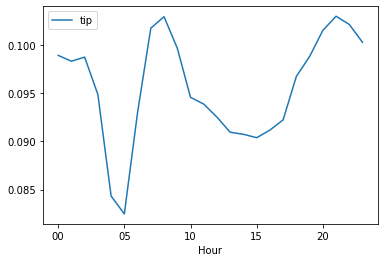

In [19]:
print(df_plot_h.plot(x='Hour',y='tip'))

AxesSubplot(0.125,0.125;0.775x0.755)


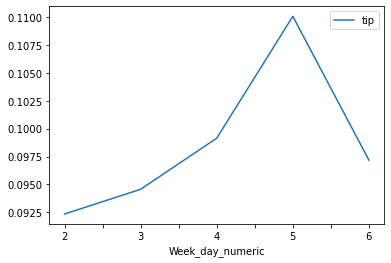

In [21]:
print(df_plot_wd.plot(x='Week_day_numeric',y='tip'))

5. Décrivez l'évolution des deux courbes :

Il semblerait que

In [29]:
timeFmt='yyyy-MM-dd HH:mm:ss'
timeDiff = (F.unix_timestamp('EndDateTime', format=timeFmt)- F.unix_timestamp('StartDateTime', format=timeFmt))

df=(df.withColumn('StartDateTime',to_timestamp("tpep_pickup_datetime",timeFmt))
    .withColumn('EndDateTime',to_timestamp("tpep_dropoff_datetime",timeFmt))
    .withColumn("Duration", timeDiff))

df_ML=df.drop("tpep_pickup_datetime",
              "tpep_dropoff_datetime",
              'StartDateTime',
              'EndDateTime',
              'store_and_fwd_flag',
              'VendorID','extra','mta_tax','total_amount')
df_ML.show(5)



+---------------+-------------+----------+------------+------------+------------+-----------+----------+------------+---------------------+-------------------+--------+
|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|fare_amount|tip_amount|tolls_amount|improvement_surcharge|       tip_fraction|Duration|
+---------------+-------------+----------+------------+------------+------------+-----------+----------+------------+---------------------+-------------------+--------+
|              1|          0.5|         1|         263|         236|           1|        4.5|       2.7|         0.0|                  0.3|0.30000000000000004|     228|
|              5|         1.34|         1|         142|         163|           1|        6.0|      1.36|         0.0|                  0.3|0.16666666666666669|     303|
|              1|         9.48|         1|          74|          66|           1|       27.0|       0.0|         0.0|                  0.3|                

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

# Load and parse the data file, converting it to a DataFrame.
data = df_ML
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.

required_features=data.columns

assembler = VectorAssembler(inputCols=required_features, outputCol='features')

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol='features',labelCol="fare_amount",numTrees=250,featureSubsetStrategy='all')

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "fare_amount", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="fare_amount",
                                predictionCol="prediction",
                                metricName="rmse")

rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

In [184]:
spark.stop()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:33259)
Traceback (most recent call last):
  File "/home/pierre/miniconda3/envs/python38/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/pierre/miniconda3/envs/python38/lib/python3.8/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
/home/pierre/miniconda3/envs/python38/lib/python3.8/site-packages/pyspark/context.py:451: RuntimeWarning: Unable to cleanly shutdown Spark JVM process. It is possible that the process has crashed, been killed or may also be in a zombie state.
  warnings.warn(
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java 

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:33259)